## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

### Analítica
Vamos a utilizar los datos de ventas de Johnson&Johnson

In [1]:
# ============================================
# IMPORTACIÓN DE LIBRERÍAS NECESARIAS
# ============================================

# Librerías para análisis de series temporales (statsmodels)
from statsmodels.tsa.stattools import pacf  # Función de autocorrelación parcial
from statsmodels.tsa.stattools import acf   # Función de autocorrelación
from statsmodels.graphics.tsaplots import plot_pacf  # Gráfico de autocorrelación parcial
from statsmodels.graphics.tsaplots import plot_acf   # Gráfico de autocorrelación
from statsmodels.tsa.stattools import adfuller  # Test de Dickey-Fuller para estacionariedad

# Librería pmdarima: facilita la creación de modelos ARIMA con búsqueda automática
from pmdarima.arima import auto_arima  # Búsqueda automática de mejores parámetros ARIMA
from pmdarima.arima import ARIMA  # Modelo ARIMA

# Librerías básicas de visualización y análisis de datos
import matplotlib.pyplot as plt  # Para crear gráficos
import pandas as pd  # Para manipulación de datos tabulares
import numpy as np  # Para operaciones numéricas
from sklearn.metrics import mean_squared_error  # Métrica para evaluar el error del modelo

# Configuración para ignorar warnings que pueden ensuciar la salida
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Si no tienes instalada la librería pmdarima, descomenta la siguiente línea:
#!pip install pmdarima

In [3]:
# ============================================
# CARGA DE DATOS DE JOHNSON & JOHNSON
# ============================================

# Cargamos el dataset de ventas trimestrales de Johnson & Johnson
# index_col=0 indica que la primera columna será el índice (fechas)
data = pd.read_csv('data/jj.csv', index_col=0)

# Verificamos cuántos registros tenemos en total
print(len(data))  # Debemos tener 84 observaciones trimestrales

# Mostramos las primeras 5 filas para entender la estructura de los datos
data.head()

84


,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


<Axes: xlabel='date'>

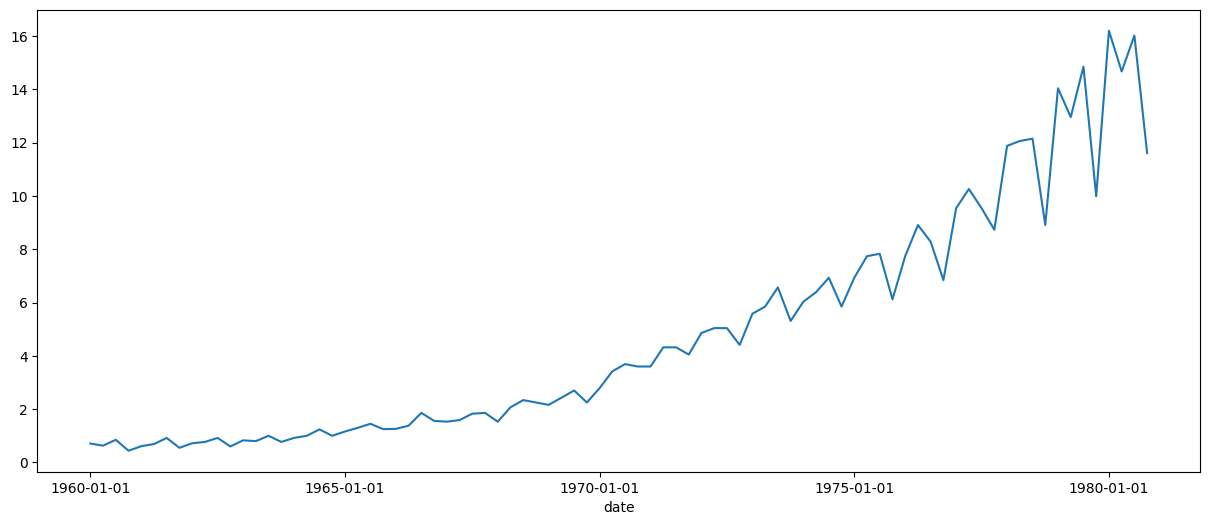

In [4]:
# ============================================
# VISUALIZACIÓN DE LA SERIE TEMPORAL
# ============================================

# Graficamos la serie temporal completa para identificar patrones visuales
# figsize=(15,6) define un gráfico ancho para apreciar mejor la evolución temporal
data['data'].plot(figsize=(15,6))

# OBSERVACIONES IMPORTANTES:
# - Se observa una tendencia creciente a lo largo del tiempo
# - La varianza parece aumentar con el tiempo (heterocedasticidad)
# - Posible presencia de estacionalidad (patrones repetitivos)
# Esto indica que la serie NO es estacionaria y necesitará diferenciación

Se aprecia en la gráfica que presenta diferentes estadísticos a lo largo del tiempo.

Representamos su gráfica de autocorrelación. Vemos que tenemos muy complicado determinar el orden p y q, de cara al modelo ARIMA.

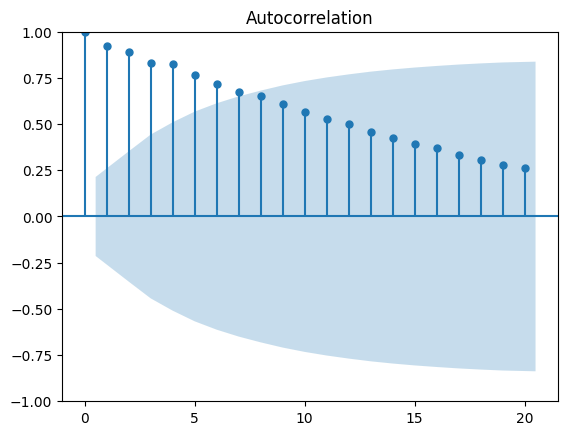

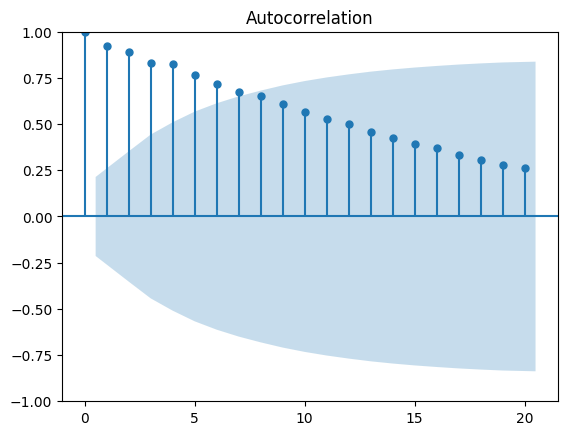

In [5]:
# ============================================
# ANÁLISIS DE AUTOCORRELACIÓN (ACF)
# ============================================

# El gráfico ACF muestra la correlación de la serie consigo misma en diferentes lags (retrasos)
plot_acf(data['data'])

# INTERPRETACIÓN:
# - Si vemos que las barras decaen muy lentamente, indica NO estacionariedad
# - Las barras que salen de la zona sombreada son estadísticamente significativas
# - Este gráfico nos ayudará a determinar el parámetro 'q' del modelo ARIMA
# - En este caso, la autocorrelación se mantiene alta por muchos lags, 
#   confirmando que necesitamos diferenciar la serie

Dividimos en train y test

In [6]:
# ============================================
# DIVISIÓN DE DATOS EN TRAIN Y TEST
# ============================================

# Extraemos todos los valores de la columna 'data' como un array numpy
X = data['data'].values

# Dividimos los datos:
# - train: primeros 70 registros (aproximadamente 83% de los datos)
# - test: últimos 14 registros (aproximadamente 17% de los datos)
train = X[:70]
test = X[70:]

# Esta división nos permitirá:
# 1. Entrenar el modelo con los datos históricos (train)
# 2. Evaluar su capacidad predictiva con datos no vistos (test)

In [7]:
# Verificamos la forma del array completo
# Debería mostrar (84,) indicando 84 observaciones en una dimensión
X.shape

(84,)

In [8]:
# Verificamos cuántas observaciones tenemos en el conjunto de test
# Debería mostrar 14 registros que usaremos para validar nuestras predicciones
len(test)

14

## Autoregressive
Tendremos que encontrar el orden de autoregression que mejor encaje con nuestros datos.

In [9]:
# ============================================
# MODELO AUTOREGRESIVO AR(1,0,0)
# ============================================

# Creamos un modelo AR puro con orden (p=1, d=0, q=0)
# - p=1: usamos solo 1 lag (observación anterior) para predecir
# - d=0: no aplicamos diferenciación (asumimos estacionariedad)
# - q=0: no usamos errores de predicción pasados
model_ar = ARIMA(order=(1,0,0))

# Ajustamos (entrenamos) el modelo con nuestros datos de entrenamiento
model_ar.fit(train)

# NOTA: Un modelo AR predice valores futuros basándose únicamente en valores pasados
# Formula: Y_t = c + φ₁*Y_{t-1} + error

,order,"(1, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


In [10]:
# ============================================
# EVALUACIÓN DEL MODELO AR(1,0,0)
# ============================================

# Generamos predicciones para los próximos 14 periodos (tamaño del conjunto test)
predictions = model_ar.predict(14)

# Calculamos el Error Cuadrático Medio (MSE) para evaluar la calidad del modelo
# MSE mide el promedio de los errores al cuadrado
# Valores más bajos indican mejores predicciones
print("mean_squared_error:", mean_squared_error(test, predictions))

# INTERPRETACIÓN:
# Un MSE de ~13.7 indica que las predicciones están bastante alejadas de los valores reales
# Esto sugiere que AR(1,0,0) no es adecuado para estos datos

mean_squared_error: 13.69881345450985


In [11]:
# Visualizamos las predicciones generadas por el modelo AR(1,0,0)
# Notaremos que son valores decrecientes que tienden a estabilizarse
model_ar.predict(14)

array([10.18960874, 10.12012387, 10.05153371,  9.98382676,  9.91699163,
        9.8510171 ,  9.78589208,  9.72160565,  9.65814699,  9.59550546,
        9.53367053,  9.47263181,  9.41237905,  9.35290214])

In [12]:
# Confirmamos que el conjunto test tiene 14 observaciones
test.shape

(14,)

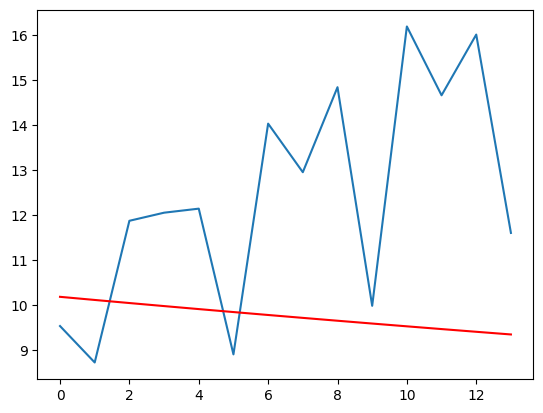

In [13]:
# ============================================
# COMPARACIÓN VISUAL: VALORES REALES VS PREDICCIONES
# ============================================

# Graficamos los valores reales del conjunto test (en azul)
plt.plot(test)

# Superponemos las predicciones del modelo (en rojo)
plt.plot(predictions, color='red')

# ANÁLISIS VISUAL:
# - La línea azul muestra los valores reales
# - La línea roja muestra nuestras predicciones
# - Si las líneas están muy separadas, el modelo no está capturando bien el patrón
# - En este caso, vemos que el modelo AR(1,0,0) NO predice bien la tendencia creciente

No parece que de buen resultado el AR(1,0,0). Probemos diferentes lags, a ver cuál sería el mejor

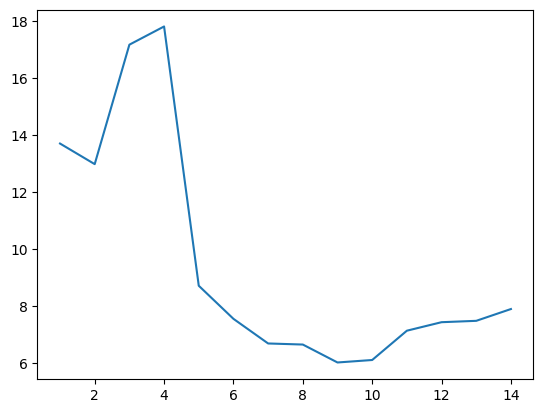

In [14]:
# ============================================
# BÚSQUEDA DEL MEJOR PARÁMETRO 'p' PARA AR
# ============================================

# Vamos a probar diferentes valores de 'p' (número de lags) para encontrar el mejor
lags = []  # Almacenaremos los valores de p probados
mse = []   # Almacenaremos el MSE correspondiente a cada p

# Iteramos desde p=1 hasta p=14
for lag in range(1, 15):
    try:
        # Creamos un modelo AR con el valor actual de p
        # order=(lag, 0, 0) significa AR(p) puro, sin diferenciación ni MA
        model_ar = ARIMA(order=(lag, 0, 0))
        model_ar.fit(train)
        
        # Guardamos el lag probado
        lags.append(lag)
        
        # Generamos predicciones y calculamos el error
        predictions = model_ar.predict(14)
        mse.append(mean_squared_error(test, predictions))
    except:
        # Algunos valores de p pueden causar errores (ej: sobreajuste)
        # En ese caso, simplemente continuamos con el siguiente
        continue

# Graficamos la evolución del MSE según el valor de p
# Buscamos el punto más bajo de la curva
plt.plot(lags, mse)

# INTERPRETACIÓN:
# - El MSE disminuye conforme aumentamos p, pero sigue siendo alto
# - Esto confirma que un modelo AR puro no es suficiente para estos datos

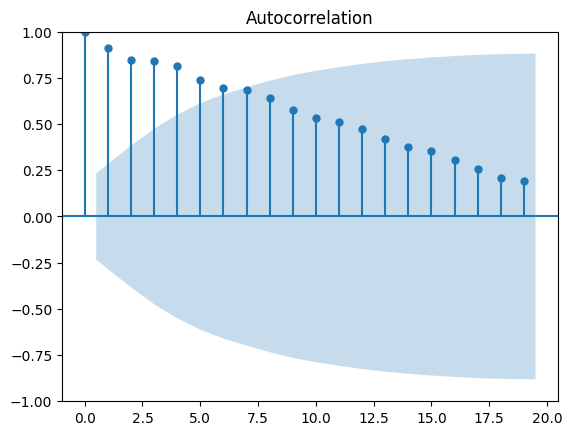

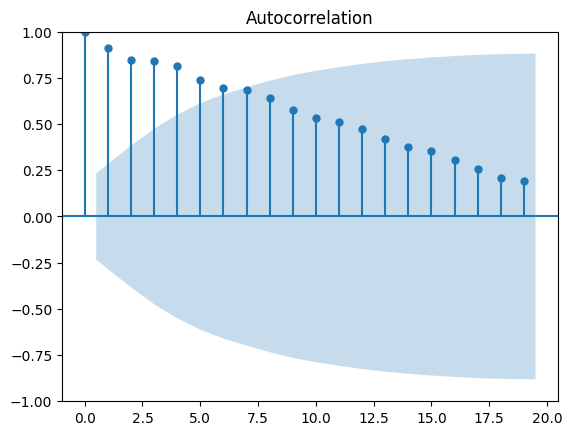

In [15]:
# Visualizamos nuevamente el gráfico ACF para el conjunto de entrenamiento
# Esto nos ayuda a entender por qué los modelos AR puros no funcionan bien
plot_acf(train)

# La autocorrelación alta en muchos lags sugiere que necesitamos:
# 1. Aplicar diferenciación (parámetro d > 0)
# 2. O incluir componentes de Media Móvil (parámetro q > 0)

Un parámetro p>5 parece que da buen resultado, pero aun asi es muy alto el error.

## Moving Average
En este caso tendremos en cuenta los errores. El problema es que si tenemos muchos errores al principio, los iremos arrastrando durante las predicciones.

In [16]:
# ============================================
# MODELO DE MEDIA MÓVIL MA(0,0,1)
# ============================================

# Creamos un modelo MA puro con orden (p=0, d=0, q=1)
# - p=0: no usamos valores pasados de la serie
# - d=0: no aplicamos diferenciación
# - q=1: usamos 1 error de predicción pasado
model_ma = ARIMA(order=(0, 0, 1))

# Ajustamos el modelo
model_ma.fit(train)

# NOTA: Un modelo MA predice valores futuros basándose en errores de predicción pasados
# Formula: Y_t = μ + error_t + θ₁*error_{t-1}
# donde error_t es la diferencia entre el valor real y el predicho en el momento t

,order,"(0, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


In [17]:
# ============================================
# EVALUACIÓN DEL MODELO MA(0,0,1)
# ============================================

# Generamos predicciones para los 14 periodos del conjunto test
predictions = model_ma.predict(14)

# Calculamos el MSE
print("mean_squared_error:", mean_squared_error(test, predictions))

# INTERPRETACIÓN:
# MSE de ~87.15 es MUCHO PEOR que el modelo AR(1,0,0) que tenía ~13.7
# Esto indica que un modelo MA puro tampoco es adecuado
# El problema es que los errores iniciales se van propagando y acumulando

mean_squared_error: 87.15679102185968


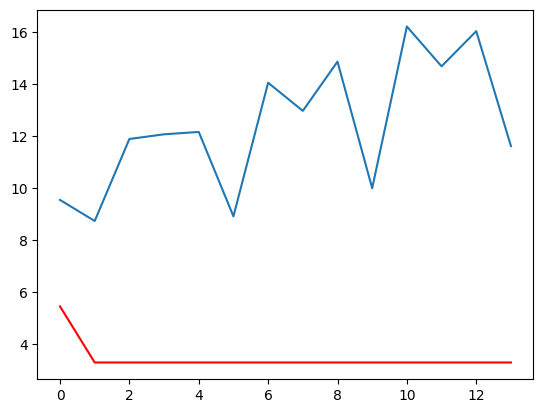

In [18]:
# Comparación visual: valores reales (azul) vs predicciones MA (rojo)
plt.plot(test)
plt.plot(predictions, color='red')

# Como podemos ver, las predicciones son casi constantes y no capturan
# la tendencia creciente de los datos reales

No está dando buen resultado. Probaremos entonces varios lags

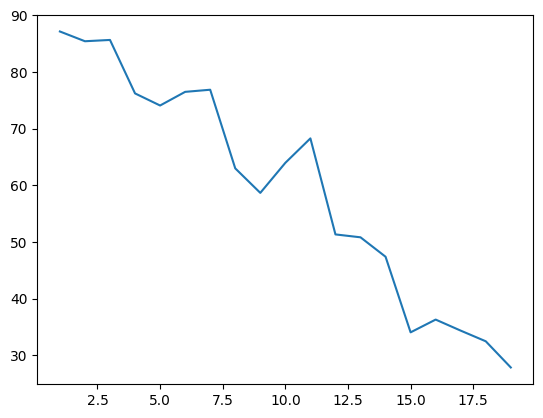

In [19]:
# ============================================
# BÚSQUEDA DEL MEJOR PARÁMETRO 'q' PARA MA
# ============================================

# Probamos diferentes valores de q (orden del componente MA)
lags = []
mse = []

for lag in range(1, 20):
    try:
        # Creamos modelo MA(0, 0, q) con diferentes valores de q
        model_ar = ARIMA(order=(0, 0, lag))
        model_ar_fit = model_ar.fit(train)
        
        # Generamos predicciones
        predictions = model_ar_fit.predict(14)
        
        # Almacenamos resultados
        lags.append(lag)
        mse.append(mean_squared_error(test, predictions))
    except:
        # Algunos valores pueden causar problemas de convergencia
        continue

# Graficamos MSE vs valor de q    
plt.plot(lags, mse)

# OBSERVACIÓN:
# El error disminuye conforme aumenta q, pero sigue siendo muy alto
# Necesitamos combinar AR y MA, además de aplicar diferenciación

Parece que según vamos aumentando el parámetro `q` del modelo Moving Average, va disminuyendo el error, pero aun así es bastante grande.

## ARIMA
En el arima no solo influyen los parámetros `p` y `q`, sino que también tendremos en cuenta `d`. Parametro con el que diferenciaremos la serie y conseguiremos que sea estacionaria.

Ahora bien, ¿cuál es la mejor combinación de parámetros? Tendremos que realizar varias pruebas. Para comparar los modelos se suele utilizar el AIC.

### AIC
Akaike’s Information Criterion


k es el número de parámetros del modelo estadístico y L es el máximo valor de la función de verosimilitud para el modelo estimado. La función de verosimilitud permite realizar inferencias a partir de u conjunto de observaciones.

Se utiliza para seleccionar el mejor modelo, que será el que tiene menor AIC. El AIC depende mucho de cada dato, y es una medida de comparación entre modelos, no de presentación de resultados. Un AIC bajo no quiere decir que el modelo sea muy bueno. Por tanto, AIC no nos dice nada sobre la calidad del modelo en terminos absolutos.


#### ¿Cómo conseguir los mejores p, d, q?

In [20]:
# ============================================
# GENERACIÓN DE COMBINACIONES DE PARÁMETROS PARA ARIMA
# ============================================

import itertools

# Definimos los rangos de búsqueda para cada parámetro
p = d = q = range(0, 5)  # Probaremos valores de 0 a 4 para p, d y q

# Generamos todas las combinaciones posibles de (p, d, q)
# itertools.product crea el producto cartesiano
pdq = list(itertools.product(p, d, q))

# Mostramos las primeras 6 combinaciones como ejemplo
pdq[:6]

# Esto generará 5×5×5 = 125 combinaciones posibles
# Ejemplo de combinaciones:
# (0,0,0) → modelo trivial sin parámetros
# (1,0,0) → AR(1) puro
# (0,0,1) → MA(1) puro
# (1,1,1) → ARIMA con todos los componentes

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0)]

In [21]:
# ============================================
# BÚSQUEDA EXHAUSTIVA DEL MEJOR MODELO ARIMA
# ============================================

results = []  # Lista para almacenar los resultados

# Probamos todas las combinaciones de (p, d, q)
for param in pdq:
    try:
        # Creamos y ajustamos el modelo ARIMA con los parámetros actuales
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train)
        
        # Guardamos la combinación de parámetros y su AIC
        # AIC (Akaike Information Criterion) mide la calidad del modelo
        # Valores más bajos de AIC indican mejores modelos
        results.append((param, model_arima_fit.aic()))
    except:
        # Algunas combinaciones pueden no converger o causar errores
        # En esos casos, simplemente las omitimos
        continue

# NOTA IMPORTANTE:
# Estamos usando AIC en lugar de MSE porque:
# 1. AIC penaliza la complejidad del modelo (evita sobreajuste)
# 2. Balancea precisión y simplicidad
# 3. Es el criterio estándar para selección de modelos ARIMA

In [22]:
# ============================================
# ANÁLISIS DE RESULTADOS: MEJORES MODELOS
# ============================================

# Convertimos los resultados a un DataFrame para facilitar el análisis
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC'])

# Ordenamos por AIC ascendente (menor AIC = mejor modelo)
resultados_df = resultados_df.sort_values('AIC')

# Mostramos los 5 mejores modelos
resultados_df.head()

# INTERPRETACIÓN:
# El mejor modelo es ARIMA(3,2,2) con AIC ≈ 36.90
# - p=3: usa los últimos 3 valores de la serie
# - d=2: aplica diferenciación de segundo orden (elimina tendencia y curva)
# - q=2: usa los últimos 2 errores de predicción
# 
# La diferenciación de orden 2 es clave aquí, ya que indica que
# la serie tiene una tendencia no lineal que requiere doble diferenciación

,ARIMA params,AIC
87,"(3, 2, 2)",36.993831
111,"(4, 2, 1)",38.206508
88,"(3, 2, 3)",38.290098
112,"(4, 2, 2)",38.648654
89,"(3, 2, 4)",40.183335


Ya tenemos la mejor combinación de parámetros para el ARIMA. Probemos el modelo

In [29]:
# ============================================
# ENTRENAMIENTO DEL MEJOR MODELO ARIMA(3,2,2)
# ============================================

# Creamos el modelo con los mejores parámetros encontrados
best_model = ARIMA(order=(3, 2, 2))

# Ajustamos el modelo con los datos de entrenamiento
best_model.fit(train)

# Este modelo combina:
# - Componente autorregresivo de orden 3 (AR(3))
# - Diferenciación de segundo orden (I(2))
# - Componente de media móvil de orden 2 (MA(2))

,order,"(3, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


In [30]:
# ============================================
# EVALUACIÓN DEL MEJOR MODELO
# ============================================

# Generamos predicciones para el conjunto test
predictions = best_model.predict(14)

# Calculamos el MSE
print("mean_squared_error:", mean_squared_error(test, predictions))

# COMPARACIÓN DE RESULTADOS:
# - AR(1,0,0): MSE ≈ 13.70
# - MA(0,0,1): MSE ≈ 87.15
# - ARIMA(3,2,2): MSE ≈ 3.93 ← ¡MUCHO MEJOR!
#
# El MSE se redujo significativamente, demostrando que:
# 1. La diferenciación era necesaria para eliminar la tendencia
# 2. Combinar componentes AR y MA mejora las predicciones

mean_squared_error: 3.946186905400194


### Auto ARIMA

In [31]:
# ============================================
# AUTO_ARIMA: BÚSQUEDA AUTOMÁTICA DE PARÁMETROS
# ============================================

# auto_arima es una función que automatiza la búsqueda de los mejores parámetros
model = auto_arima(train,
                   start_p=1,      # Valor inicial de p para la búsqueda
                   start_q=1,      # Valor inicial de q para la búsqueda
                   max_p=5,        # Valor máximo de p a probar
                   max_q=5,        # Valor máximo de q a probar
                   max_d=3,        # Valor máximo de d a probar
                   trace=True)     # Mostrar el proceso de búsqueda

# VENTAJAS DE AUTO_ARIMA:
# 1. No necesitas probar manualmente todas las combinaciones
# 2. Usa búsqueda stepwise (más eficiente que grid search)
# 3. Aplica tests estadísticos para determinar d automáticamente
# 4. Minimiza el AIC por defecto
#
# El parámetro trace=True nos muestra cada modelo probado y su AIC,
# permitiéndonos ver el proceso de optimización

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=138.619, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=196.672, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=180.443, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=140.942, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=113.935, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=166.323, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=47.310, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=44.000, Time=0.17 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=43.451, Time=0.19 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=51.018, Time=0.16 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=40.771, Time=0.25 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=44.616, Time=0.24 sec
 ARIMA(5,2,3)(0,0,0)[0]             : AIC=42.801, Time=0.29 s

In [32]:
# ============================================
# RESUMEN DEL MODELO ENCONTRADO POR AUTO_ARIMA
# ============================================

# Recreamos el modelo con los parámetros óptimos encontrados
model = ARIMA(order=(3, 2, 2))
model.fit(train)

# Mostramos el resumen estadístico completo del modelo
print(model.summary())

# EL RESUMEN INCLUYE:
# 1. Coeficientes estimados: valores de los parámetros AR y MA
# 2. P-valores: significancia estadística de cada coeficiente
# 3. AIC/BIC: criterios de información para comparar modelos
# 4. Tests de diagnóstico:
#    - Ljung-Box: verifica si los residuos son ruido blanco
#    - Jarque-Bera: verifica normalidad de los residuos
#    - Heteroskedasticity: verifica varianza constante de los residuos

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 -11.497
Date:                Thu, 20 Nov 2025   AIC                             36.994
Time:                        12:31:12   BIC                             52.530
Sample:                             0   HQIC                            43.150
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0174      0.002      7.173      0.000       0.013       0.022
ar.L1         -1.1098      0.054    -20.598      0.000      -1.215      -1.004
ar.L2         -1.0935      0.050    -21.805      0.0

## ARIMAX
La X viene de exogenous. Significa que le podemos añadir una variable externa con la que entrenar el modelo.

Vamos a probar con los datos de la bolsa. Primero un auto_arima con los datos a cierre. Y después un auto_arima acompañado de los datos de apertura de bolsa, a ver cuánto ayudan a predecir el cierre.

In [33]:
# ============================================
# CARGA DE DATOS DE BOLSA (FACEBOOK)
# ============================================

# Cargamos datos históricos de acciones de Facebook
stock_df = pd.read_csv('data/FB.csv', header=0, index_col=0)

# Verificamos la cantidad de registros
print(len(stock_df))  # 1259 días de cotizaciones

# Mostramos las primeras filas
stock_df.head()

# COLUMNAS DEL DATASET:
# - Open: precio de apertura
# - High: precio máximo del día
# - Low: precio mínimo del día
# - Close: precio de cierre (variable objetivo)
# - Adj Close: precio ajustado por dividendos/splits
# - Volume: volumen de transacciones

1259


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600


<Axes: xlabel='Date'>

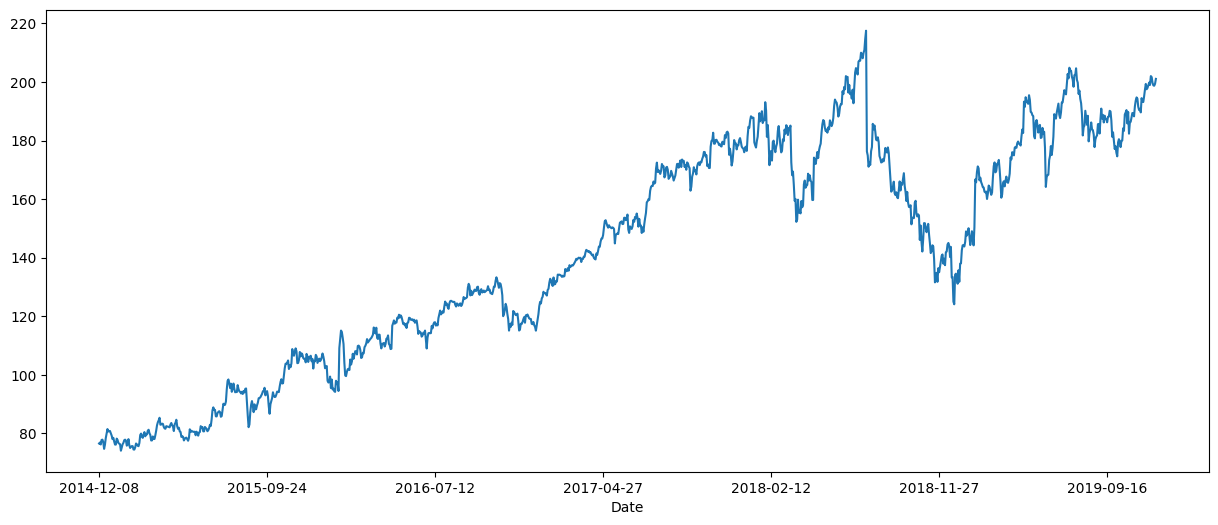

In [34]:
# Visualizamos la evolución del precio de cierre a lo largo del tiempo
stock_df['Close'].plot(figsize=(15, 6))

# Se observa alta volatilidad, tendencias cambiantes y posibles patrones
# que podrían ser capturados por un modelo ARIMA

Vemos primero ejemplo sin variable exogena

In [35]:
# ============================================
# DIVISIÓN TRAIN/TEST PARA DATOS DE BOLSA
# ============================================

# Dividimos los datos:
# - train: primeros 1240 días (98.5% de los datos)
# - test: últimos 19 días (1.5% de los datos)
train = stock_df['Close'][0:1240].values
test = stock_df['Close'][1240:].values

# Usamos solo la columna 'Close' porque queremos predecir el precio de cierre

Vamos a probar varios ARIMAS, a ver cuál sería la mejor combinación de hiperparámetros.

In [36]:
# ============================================
# AUTO_ARIMA SIN VARIABLE EXÓGENA (BASELINE)
# ============================================

# Primero probamos un ARIMA tradicional sin información adicional
stepwise_model = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_d=3,
                            max_p=5,
                            max_q=5,
                            stationary=False,  # No asumimos estacionariedad
                            trace=True,         # Mostramos el proceso
                            stepwise=True)      # Búsqueda stepwise (más rápida)

# Mostramos el AIC del mejor modelo encontrado
print(stepwise_model.aic())

# Este modelo solo usa información histórica del precio de cierre
# No incorpora ninguna otra variable que pudiera ayudar a predecir

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5973.080, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5975.597, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5977.174, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5977.161, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5975.049, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5974.760, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5978.841, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5978.892, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5973.656, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.697 seconds
5973.079582445727


Ya lo tenemos, ahora montaremos el modelo con esos hiperparámetros y vemos que AIC tiene.

In [37]:
# Creamos el modelo con los parámetros encontrados: ARIMA(1,1,1)
model = ARIMA(order=(1, 1, 1))
model.fit(train)

# Mostramos el resumen completo
print(model.summary())

# El AIC resultante es ~5973.08
# Este será nuestro punto de referencia (baseline) para comparar
# con el modelo ARIMAX que incluirá variables exógenas

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2982.540
Date:                Thu, 20 Nov 2025   AIC                           5973.080
Time:                        12:33:38   BIC                           5993.568
Sample:                             0   HQIC                          5980.785
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.066      0.287      -0.010       0.035
ar.L1          0.8643      0.086     10.027      0.000       0.695       1.033
ma.L1         -0.9008      0.075    -11.994      0.0

In [38]:
# Generamos predicciones para los 19 días de test
predictions = model.predict(19)

# Calculamos el MSE
print("mean_squared_error:", mean_squared_error(test, predictions))

# MSE ≈ 45.03 indica el error promedio al cuadrado de nuestras predicciones
# Usaremos este valor para comparar con el modelo ARIMAX

mean_squared_error: 45.03300712707942


Vamos ahora a compararlo con el mismo modelo, pero en este caso le añadimos una variable exogena al entrenamiento

In [39]:
# Verificamos la forma de los datos de apertura que usaremos como variable exógena
# Los transformamos en un array 2D con reshape(-1, 1) porque ARIMA lo requiere
stock_df[['Open']][:1240].values

# La variable exógena 'Open' (precio de apertura) puede ayudar a predecir 'Close'
# porque existe correlación entre el precio de apertura y cierre del mismo día

array([[ 76.18    ],
       [ 75.199997],
       [ 76.650002],
       ...,
       [194.029999],
       [191.910004],
       [190.      ]], shape=(1240, 1))

In [40]:
# ============================================
# ARIMAX: ARIMA CON VARIABLE EXÓGENA
# ============================================

# Creamos el mismo modelo ARIMA(1,1,1) pero ahora incluyendo información adicional
model = ARIMA(order=(1, 1, 1))

# Ajustamos el modelo pasando la variable exógena 'Open' (precio de apertura)
# exogeneous: datos externos que pueden ayudar a mejorar las predicciones
# reshape(-1, 1): convierte el array a formato columna (requerido por ARIMA)
model.fit(train, exogeneous=stock_df['Open'][:1240].values.reshape(-1, 1))

print(model.summary())

# CONCEPTO CLAVE - ARIMAX:
# La "X" en ARIMAX significa "eXogenous" (variable externa)
# El modelo ahora considera:
# 1. Valores pasados de Close (componente AR)
# 2. Diferencias de Close (componente I)
# 3. Errores pasados (componente MA)
# 4. + Precio de apertura como predictor adicional (componente X)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1240
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2982.540
Date:                Thu, 20 Nov 2025   AIC                           5973.080
Time:                        12:34:52   BIC                           5993.568
Sample:                             0   HQIC                          5980.785
                               - 1240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0125      0.012      1.066      0.287      -0.010       0.035
ar.L1          0.8643      0.086     10.027      0.000       0.695       1.033
ma.L1         -0.9008      0.075    -11.994      0.0

Reduce bastante el AIC

Probemos a entrenar el auto arima con la variable exogena

In [41]:
# ============================================
# AUTO_ARIMA CON UNA VARIABLE EXÓGENA
# ============================================

# Ahora dejamos que auto_arima encuentre los mejores parámetros
# pero incluyendo la variable exógena 'Open'
model = auto_arima(train,
                   # Variable exógena: precio de apertura
                   exogeneous=stock_df['Open'][:1240].values.reshape(-1, 1),
                   start_p=1,
                   start_q=1,
                   max_d=3,
                   max_p=5,
                   max_q=5,
                   stationary=False,
                   trace=True,
                   stepwise=True)

print(model.aic())

# COMPARACIÓN:
# - ARIMA sin variable exógena: AIC ≈ 5973.08
# - ARIMAX con 'Open': AIC ≈ 5973.08 (similar)
#
# En este caso, añadir 'Open' no mejora significativamente el modelo
# porque 'Open' y 'Close' están muy correlacionados de forma lineal

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5973.080, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5975.597, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5977.174, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5977.161, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5975.049, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5974.760, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5978.841, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5978.892, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5973.656, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.721 seconds
5973.079582445727


Probemos varias variables exogenas

NOTA: para este apartado se utiliza el valor 'Low', que en la vida real no lo tendriamos para realizar la predicción.

In [42]:
# ============================================
# ARIMAX CON MÚLTIPLES VARIABLES EXÓGENAS
# ============================================

# Probamos con DOS variables exógenas: 'Open' y 'Low'
model = auto_arima(train,
                   # NOTA: usamos [['Open', 'Low']] para seleccionar múltiples columnas
                   exogeneous=stock_df[['Open', 'Low']][:1240].values,
                   start_p=1,
                   start_q=1,
                   max_d=3,
                   max_p=5,
                   max_q=5,
                   stationary=False,
                   trace=True,
                   stepwise=True)

print(model.aic())

# ADVERTENCIA IMPORTANTE:
# Este ejemplo usa 'Low' (precio mínimo del día) como variable exógena
# En la vida real, NO tendríamos el valor 'Low' del día al momento de
# predecir el precio de cierre, porque ambos ocurren simultáneamente
# 
# Variables exógenas válidas serían:
# - Indicadores técnicos calculados con datos pasados
# - Volumen de transacciones del día anterior
# - Índices de mercado externos
# - Sentimiento de noticias, etc.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5973.080, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5975.597, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5977.174, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5977.161, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5975.049, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5974.760, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5978.841, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5978.892, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5973.656, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.754 seconds
5973.079582445727


## SARIMA
Veamos cómo podemos predecir con datos que tienen estacionalidad, es decir, que cuentan con un patrón que se repite a lo largo del tiempo.

In [43]:
# ============================================
# CARGA DE DATOS CON ESTACIONALIDAD
# ============================================

# Cargamos datos de ventas de medicamentos antidiabéticos en Australia
# parse_dates: convierte la columna 'date' a formato datetime
# index_col: usa 'date' como índice del DataFrame
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')

print(len(df))  # 204 observaciones mensuales
df.head()

# Estos datos tienen un patrón estacional (se repite anualmente)
# porque las ventas de medicamentos pueden variar según la época del año

204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


<Axes: xlabel='date'>

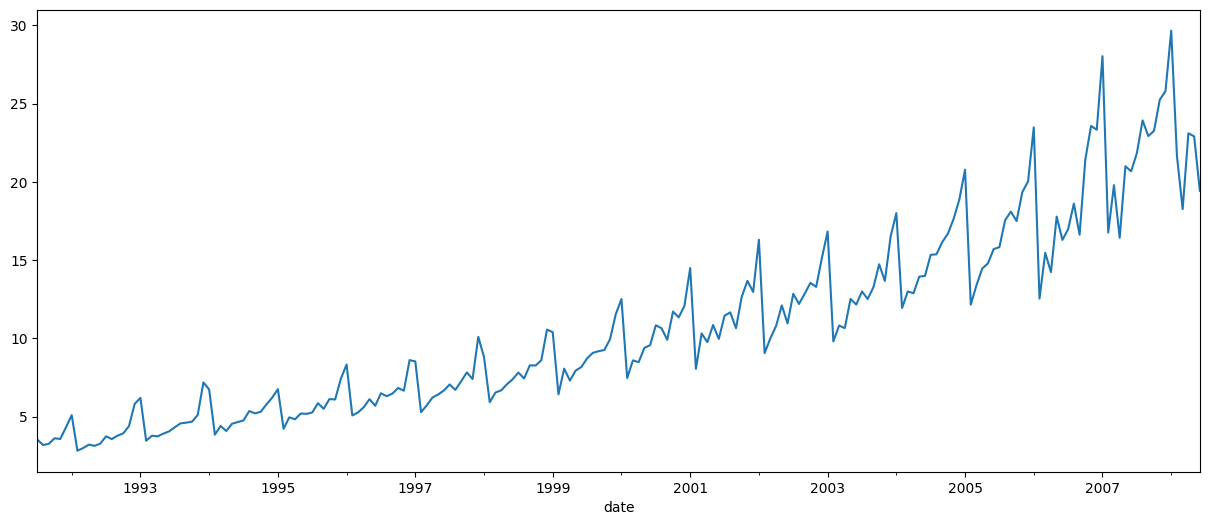

In [44]:
# Visualizamos la serie temporal
df['value'].plot(figsize=(15, 6))

# OBSERVACIONES VISUALES:
# 1. Tendencia creciente a largo plazo
# 2. Oscilaciones regulares (estacionalidad) que se repiten cada año
# 3. La amplitud de las oscilaciones aumenta con el tiempo
# 
# Esto indica que necesitamos un modelo SARIMA que capture
# tanto la tendencia como la estacionalidad

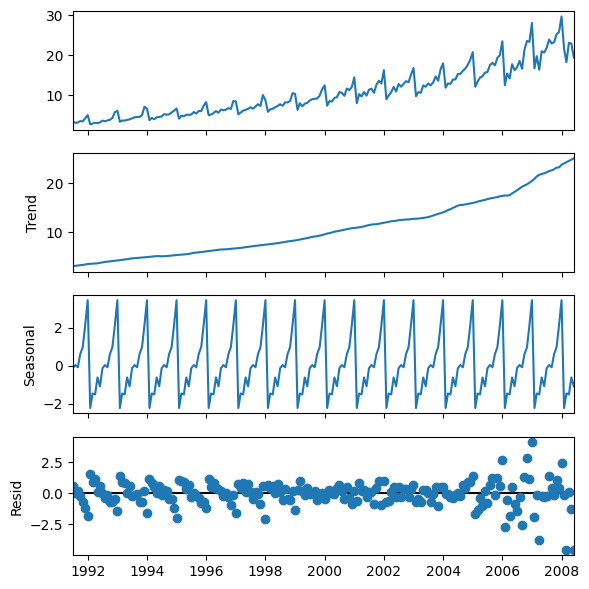

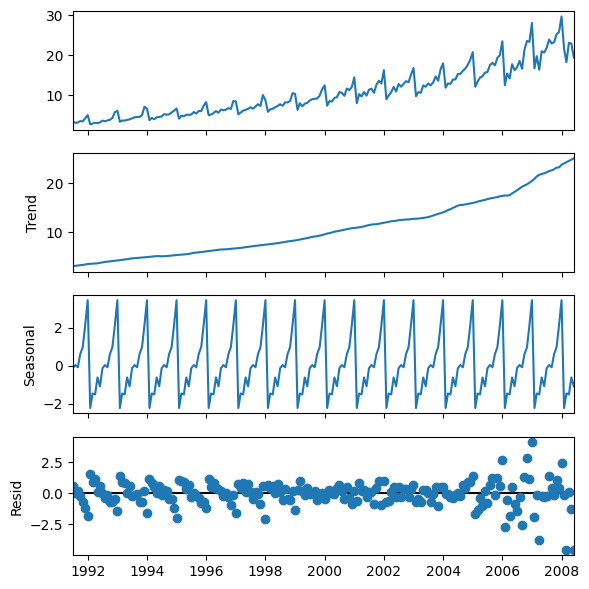

In [45]:
# ============================================
# DESCOMPOSICIÓN ESTACIONAL
# ============================================

from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponemos la serie en sus componentes
# model='additive': asumimos que los componentes se suman (Y = Trend + Seasonal + Residual)
# extrapolate_trend='freq': extiende la tendencia en los extremos
result_add = seasonal_decompose(df[['value']], model='additive', extrapolate_trend='freq')

# Configuramos el tamaño de la figura
plt.rcParams.update({'figure.figsize': (6, 6)})

# Graficamos la descomposición
result_add.plot()

# COMPONENTES VISUALIZADOS:
# 1. Observed: serie original
# 2. Trend: tendencia a largo plazo (crecimiento general)
# 3. Seasonal: patrón que se repite cada 12 meses
# 4. Residual: variación aleatoria no explicada por tendencia ni estacionalidad
#
# Esta descomposición confirma la presencia de estacionalidad clara

In [46]:
# ============================================
# DIVISIÓN TRAIN/TEST PARA DATOS ESTACIONALES
# ============================================

X = df[['value']]

# Dividimos:
# - train: todos los datos excepto los últimos 20
# - test: últimos 20 meses
train = X[:-20]
test = X[-20:]

# Reservamos aproximadamente 1 año y 8 meses para validación

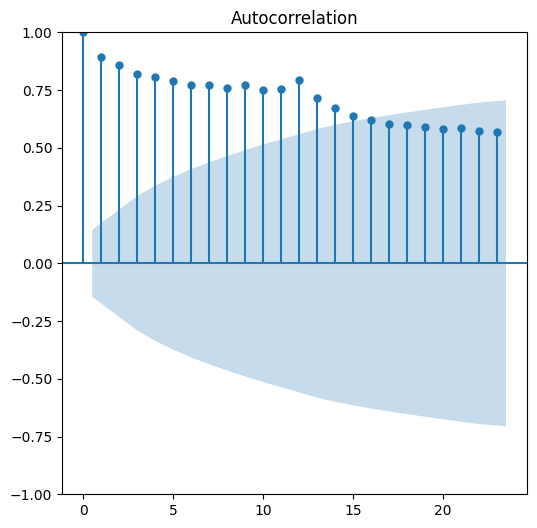

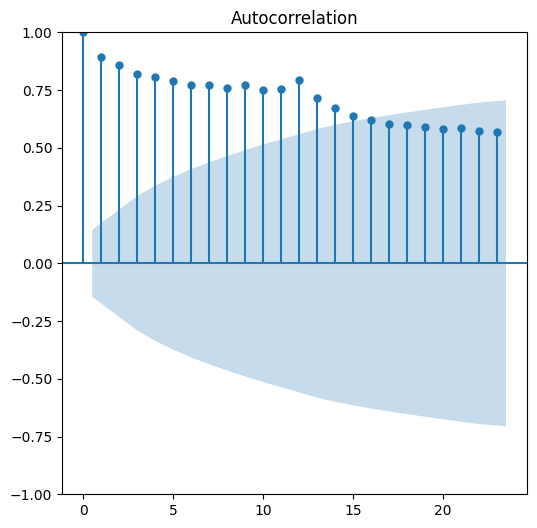

In [47]:
# Graficamos la autocorrelación del conjunto de entrenamiento
plot_acf(train)

# La ACF muestra un patrón ondulatorio que se repite
# Esto es característico de datos con estacionalidad
# Las barras significativas cada ~12 lags confirman estacionalidad anual

Probemos el auto arima sin indicarle que hay componente de seasonality

In [48]:
# ============================================
# AUTO_ARIMA SIN COMPONENTE ESTACIONAL (INCORRECTO)
# ============================================

# Primero probamos auto_arima SIN indicar que hay estacionalidad
# Esto nos servirá como baseline para comparar
model = auto_arima(train,
                   start_p=1,
                   start_q=1,
                   max_d=3,
                   max_p=5,
                   max_q=5,
                   trace=True,
                   stepwise=True)

print(model.aic())

# Generamos predicciones
predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

# RESULTADO ESPERADO:
# El modelo encontrará buenos parámetros (p,d,q) para la tendencia
# PERO no capturará el patrón estacional porque no se lo indicamos
# Por tanto, el MSE será relativamente alto (≈19.52)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=698.391, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=764.142, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=739.394, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=708.405, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=762.612, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=700.332, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=700.362, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=699.998, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=736.404, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=695.600, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=697.194, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=697.299, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=700.821, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=699.306, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, 

Ahora le añadimos el componente seasonality mediante el parametro `m`.

In [49]:
# ============================================
# SARIMA: AUTO_ARIMA CON ESTACIONALIDAD
# ============================================

# Ahora incluimos el parámetro m=12 para indicar estacionalidad
model = auto_arima(train,
                   start_p=1,
                   start_q=1,
                   max_d=3,
                   max_p=5,
                   max_q=5,
                   m=12,           # CLAVE: periodo estacional de 12 meses
                   trace=True,
                   stepwise=True)

print(model.aic())

# Generamos predicciones
predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

# MODELO SARIMA: ARIMA(p,d,q)(P,D,Q)[m]
# - (p,d,q): componentes ARIMA tradicionales para la tendencia
# - (P,D,Q): componentes ARIMA para la estacionalidad
# - [m]: periodo estacional (12 = anual)
#
# RESULTADOS ESPERADOS:
# - AIC mucho menor (≈346.05 vs ≈671.52)
# - MSE mucho menor (≈11.36 vs ≈19.52)
# 
# INTERPRETACIÓN:
# El mejor modelo es ARIMA(3,1,2)(2,1,0)[12]
# - (3,1,2): tendencia con AR(3), I(1), MA(2)
# - (2,1,0)[12]: estacionalidad con AR estacional de orden 2 y diferenciación estacional
# - El componente estacional captura el patrón que se repite cada 12 meses

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=359.383, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=480.967, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=391.380, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=366.538, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=357.778, Time=0.14 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=367.053, Time=0.04 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=358.591, Time=0.42 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=361.813, Time=0.11 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=357.470, Time=0.71 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=356.290, Time=0.58 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=354.319, Time=0.41 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=353.117, Time=0.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=362.795, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=378.264, Time=0.17 sec
 ARIMA(2,1,1)(2,1,0)[12]         